Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
from IPython.display import Image
import os, random
examples = list();
for folder in train_folders:    
    examples.append(folder + '/' + random.choice(os.listdir(folder))) #change dir name to whatever
    
print("The training folders are:")
print(train_folders)
print("The training examples are:")
print(examples)
print('Random exaplmes for each letter:')
for file in examples:
    display(Image(filename=file))
#Image(filename='test.png') 

The training folders are:
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
The training examples are:
['./notMNIST_large/A/U3RhbmRhcmQtUmVndWxhci5vdGY=.png', './notMNIST_large/B/U2Fudml0by1MaWdodC5vdGY=.png', './notMNIST_large/C/U3dpc3MgNzIxIEJvbGQgQ29uZGVuc2VkIE91dGxpbmUgQlQudHRm.png', './notMNIST_large/D/UENTdW5zaG9lLnR0Zg==.png', './notMNIST_large/E/SW5ncmlhbmFFeHRyYUJvbGQudHRm.png', './notMNIST_large/F/Um90aXNTYW5zU2VyaWZTdGQtTGlnaHRJdGFsaWMub3Rm.png', './notMNIST_large/G/T3B0aW1hTm92YUxULUJvbGRTQy5vdGY=.png', './notMNIST_large/H/QXJjaGlhbi1Jbml0aWFsLm90Zg==.png', './notMNIST_large/I/Rmx5SGlnaCBCb2xkSXRhbGljLnR0Zg==.png', './notMNIST_large/J/QmlydGhkYXlEaWdpdHMudHRm.png']
Random exaplmes for each letter:


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images, max_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
      if num_images == max_num_images:
        break
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, max_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class, max_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000, 52909)
test_datasets = maybe_pickle(test_folders, 1800, 1872)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']
Number of samples in database:./notMNIST_large/A.pickle is: 52909
Displaying sample n: 25966
Number of samples in database:./notMNIST_large/B.pickle is: 52909
Displaying sample n: 34965
Number of samples in database:./notMNIST_large/C.pickle is: 52909
Displaying sample n: 23125
Number of samples in database:./notMNIST_large/D.pickle is: 52909
Displaying sample n: 5660
Number of samples in database:./notMNIST_large/E.pickle is: 52909
Displaying sample n: 33155
Number of samples in database:./notMNIST_large/F.pickle is: 52909
Displaying sample n: 2334
Number of samples in database:./notMNIST_large/G.pickle is: 52909
Displaying sample n: 32340
Number of samples in database:./notMNIST_large/H.pickle is: 

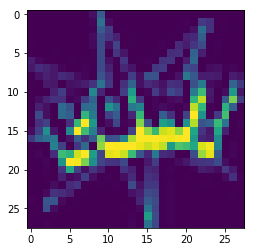

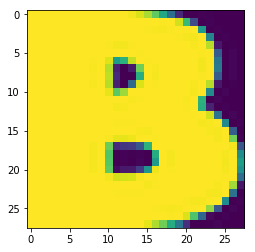

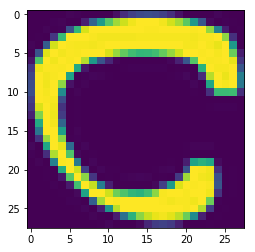

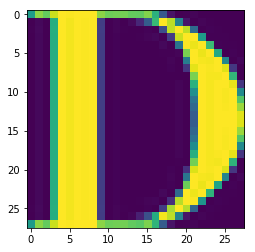

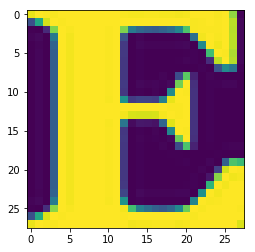

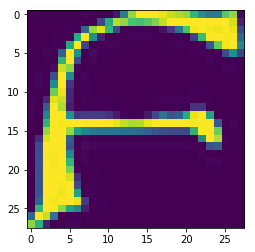

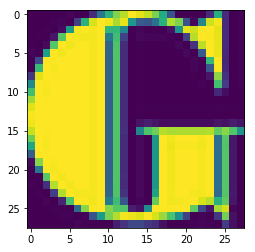

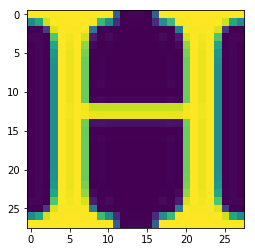

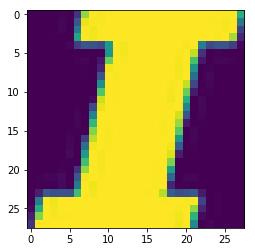

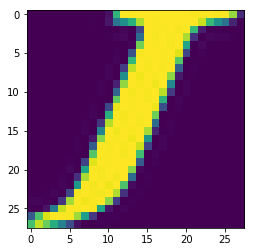

In [6]:
print(train_datasets)
count = 1
for dataset in train_datasets:
    letter = pickle.load( open( dataset, "rb" ) )
    print('Number of samples in database:' + dataset + ' is: ' + str(letter.shape[0]))
    number = random.randint(0,letter.shape[0]-1)
    print('Displaying sample n: ' + str(number))
    plt.figure(count)
    plt.imshow(letter[number,:,:])
    count += 1

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
sizes = list()
print("Train datasets")
count = 1
for dataset in train_datasets:
    letter = pickle.load( open( dataset, "rb" ) )
    sizes.append(letter.shape[0])

print(sizes)
sizes_np = np.array(sizes)
print('The mean is: ' + str(np.mean(sizes_np)))
print('Standard deviation is: ' + str(np.std(sizes_np)))
print('A perfect balanced dataset shall contain: ' + str(np.min(sizes_np)) + ' samples per dataset.')
print('Maximum train datadet size is: ' + str(len(sizes) * np.min(sizes_np)))

print("Test datasets")
sizes = list()
count = 1
for dataset in test_datasets:
    letter = pickle.load( open( dataset, "rb" ) )
    sizes.append(letter.shape[0])

print(sizes)
sizes_np = np.array(sizes)
print('The mean is: ' + str(np.mean(sizes_np)))
print('Standard deviation is: ' + str(np.std(sizes_np)))
print('A perfect balanced dataset shall contain: ' + str(np.min(sizes_np)) + ' samples per dataset.')
print('Maximum test datadet size is: ' + str(len(sizes) * np.min(sizes_np)))

Train datasets
[52909, 52909, 52909, 52909, 52909, 52909, 52909, 52909, 52909, 52909]
The mean is: 52909.0
Standard deviation is: 0.0
A perfect balanced dataset shall contain: 52909 samples per dataset.
Maximum train datadet size is: 529090
Test datasets
[1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872, 1872]
The mean is: 1872.0
Standard deviation is: 0.0
A perfect balanced dataset shall contain: 1872 samples per dataset.
Maximum test datadet size is: 18720


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 509090
valid_size = 20000
test_size = 18720

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (509090, 28, 28) (509090,)
Validation: (20000, 28, 28) (20000,)
Testing: (18720, 28, 28) (18720,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

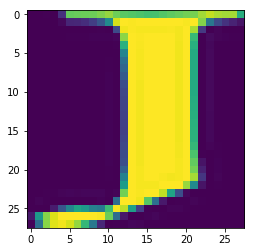

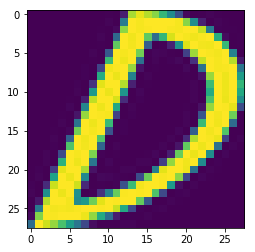

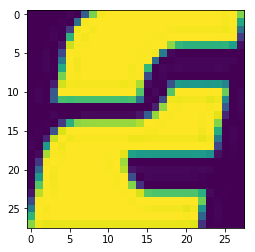

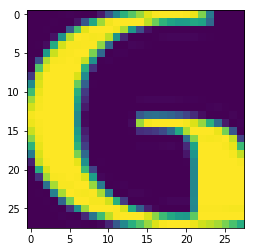

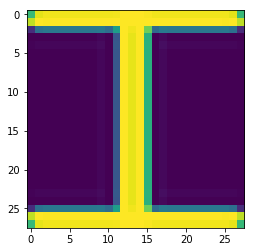

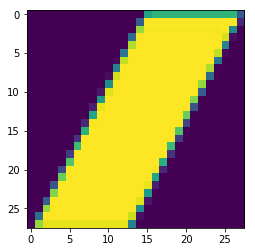

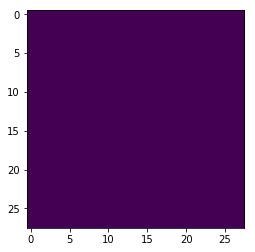

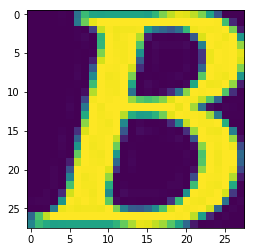

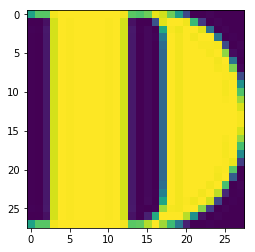

In [10]:
for count in range(1,10):
    number = random.randint(1,train_dataset.shape[0])
    plt.figure(count)
    plt.imshow(train_dataset[number,:,:])

Finally, let's save the data for later reuse:

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1720123841


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [13]:
train_dataset.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [14]:
a = [i for i in range(1,10)]
print(a)
count = 0
for image in train_dataset:
    count += 1
print(count)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
509090


In [15]:
import hashlib
import time

train_dataset.flags.writeable=False
valid_dataset.flags.writeable=False
test_dataset.flags.writeable=False

def calculate_duplicates1(dataset, dataset_name):
    start = time.clock()
    dup_table={}
    num_dup=0
    for idx,img in enumerate(dataset):
        h = hashlib.sha256(img).hexdigest()# here the idea is that the duplicated img.data array will hash to the same bucket. 
        if h in dup_table and (dataset[dup_table[h]].data == img.data):#this means the hash function value 
            #is the same as an existing hashed entry, and also their data are the same, double sure. 
            #print ('Duplicate image: %d matches %d' % (idx, dup_table[h]))
            num_dup+=1
        dup_table[h] = idx
    print('Found from '+dataset_name+' in '+str(time.clock() - start)+' s '+str(num_dup)+ ' duplicates.')
    return num_dup

def calculate_duplicates2(dataset, dataset_name):
    start = time.clock()
    len_raw_data = len(dataset)
    dataset_hash = set([hashlib.sha256(img).hexdigest() for img in dataset])
    num_dup = len_raw_data - len(dataset_hash)
    
    print('Found from '+dataset_name+' in '+str(time.clock() - start)+' s '+str(num_dup)+ ' duplicates.')
    return num_dup

def calculate_overlap1(dataset_1, dataset_2, dataset1_name, dataset2_name):
    start = time.clock()
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    n_duplicates = 0
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
            n_duplicates += len(duplicates[0])
    
    print('Overlap of '+str(n_duplicates)+' between '+dataset1_name+' and '+dataset2_name+' foun in '+str(time.clock() - start)+' s.')
    return n_duplicates
    

def calculate_overlap2(dataset_1, dataset_2, dataset1_name, dataset2_name):
    start = time.clock()
    dataset_hash_1 = set([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = set([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = set.intersection(dataset_hash_1,dataset_hash_2)
    n_duplicates = len(overlap)
    print('Overlap of ' +str(n_duplicates)+' between '+dataset1_name+' and '+dataset2_name+' foun in '+str(time.clock() - start)+' s.')
    return overlap, n_duplicates, time.clock() - start

def remediate_duplicates(dataset, labels, dataset_name):
    start = time.clock()
    dup_table={}
    duplicates = []
    num_dup=0
    for idx,img in enumerate(dataset):
        h = hashlib.sha256(img).hexdigest()# here the idea is that the duplicated img.data array will hash to the same bucket. 
        if h in dup_table and (dataset[dup_table[h]].data == img.data):#this means the hash function value 
            #is the same as an existing hashed entry, and also their data are the same, double sure. 
            #print ('Duplicate image: %d matches %d' % (idx, dup_table[h]))
            duplicates.append(dup_table[h])
            num_dup+=1
        dup_table[h] = idx
        
        #dataset.flags.writeable=True
    duplicates_np = np.array(duplicates).astype(int) 
    dataset_remediated = np.delete(dataset,duplicates_np,0)
    labels_remediated = np.delete(labels,duplicates,0)
    
    print('Remediated ' +str(len(duplicates_np))+' duplicates in '+dataset_name+ ' in '+str(time.clock() - start)+' s.')
    return dataset_remediated, labels_remediated

def remediate_overlap(dataset_1, dataset_2, labels1, labels2, dataset1_name, dataset2_name):
    start = time.clock()
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap_1 = np.array([])
    overlap_2 = np.array([])
    n_duplicates = 0
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap_1 = np.concatenate([overlap_1,np.array([i])])
            overlap_2 = np.concatenate([overlap_2,duplicates[0]])
            #print('Overlap: '+ str(duplicates))
            n_duplicates += len(duplicates[0])
            
    dataset_1_remediated = np.delete(dataset_1,np.unique(overlap_1).astype(int),0)
    dataset_2_remediated = np.delete(dataset_2,np.unique(overlap_2).astype(int),0)
    labels1_remediated = np.delete(labels1,np.unique(overlap_1).astype(int),0)
    labels2_remediated = np.delete(labels2,np.unique(overlap_2).astype(int),0)
    print('Remediated ' +str(n_duplicates)+' duplicates between '+dataset1_name+' and '+dataset2_name+' in '+str(time.clock() - start)+' s.')
    return dataset_1_remediated, dataset_2_remediated, labels1_remediated, labels2_remediated
    
#----------------------------------------------------------------------------------------------------------   
print('Evaluating fastest overlap and duplicate search method:')
print('Method1:')
calculate_duplicates1(valid_dataset, 'Validation Dataset')
calculate_overlap1(valid_dataset, test_dataset,'Validation Dataset', 'Test Dataset')
print('Method2:')
calculate_duplicates2(valid_dataset, 'Validation Dataset')
calculate_overlap2(valid_dataset, test_dataset,'Validation Dataset', 'Test Dataset')
print('Removing duplicates and overlap. This may take some time...')
train_datasetnd, train_labelsnd = remediate_duplicates(train_dataset, train_labels, 'Training Dataset')
#del train_dataset, train_labels
valid_datasetnd, valid_labelsnd = remediate_duplicates(valid_dataset, valid_labels, 'Validation Dataset')
#del valid_dataset, valid_labels
test_datasetnd, test_labelsnd = remediate_duplicates(test_dataset, test_labels, 'Test Dataset')
#del test_dataset, test_labels
print('Done with duplicates, now removing overlap')
test_dataset_no1, valid_dataset_no1, test_labels_no1, valid_labels_no1 = remediate_overlap(test_datasetnd, valid_datasetnd, test_labelsnd, valid_labelsnd, 'Test Dataset', 'Validation Dataset')
del test_datasetnd, valid_datasetnd, test_labelsnd, valid_labelsnd
valid_dataset_no2, train_dataset_no1, valid_labels_no2, train_labels_no1 = remediate_overlap(valid_dataset_no1, train_datasetnd, valid_labels_no1, train_labelsnd, 'Validation Dataset', 'Training Dataset')
del valid_dataset_no1, train_datasetnd, valid_labels_no1, train_labelsnd
train_dataset_no2, test_dataset_no2, train_labels_no2, test_labels_no2 = remediate_overlap(train_dataset_no1, test_dataset_no1, train_labels_no1, test_labels_no1, 'Training Dataset', 'Test Dataset')
del train_dataset_no1, test_dataset_no1, train_labels_no1, test_labels_no1


Evaluating fastest overlap and duplicate search method:
Method1:
Found from Validation Dataset in 0.23454 s 355 duplicates.
Overlap of 60992 between Validation Dataset and Test Dataset foun in 4.559283 s.
Method2:
Found from Validation Dataset in 0.234985 s 355 duplicates.
Overlap of 242 between Validation Dataset and Test Dataset foun in 0.446536 s.
Removing duplicates and overlap. This may take some time...
Remediated 62885 duplicates in Training Dataset in 6.803391 s.
Remediated 355 duplicates in Validation Dataset in 0.261696 s.
Remediated 492 duplicates in Test Dataset in 0.243864 s.
Done with duplicates, now removing overlap
Remediated 242 duplicates between Test Dataset and Validation Dataset in 4.428914 s.
Remediated 3817 duplicates between Validation Dataset and Training Dataset in 104.151272 s.
Remediated 4341 duplicates between Training Dataset and Test Dataset in 93.56043 s.


In [16]:
print('Training:', train_dataset_no2.shape, train_labels_no2.shape)
print('Validation:', valid_dataset_no2.shape, valid_labels_no2.shape)
print('Testing:', test_dataset_no2.shape, test_labels_no2.shape)

pickle_file = os.path.join(data_root, 'notMNIST_noDupNorOvlp.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_no2,
    'train_labels': train_labels_no2,
    'valid_dataset': valid_dataset_no2,
    'valid_labels': valid_labels_no2,
    'test_dataset': test_dataset_no2,
    'test_labels': test_labels_no2,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

Training: (438047, 28, 28) (438047,)
Validation: (15586, 28, 28) (15586,)
Testing: (13645, 28, 28) (13645,)


In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1467253361



Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

Accuracy: 0.6397970085470085 when sample_size= 50


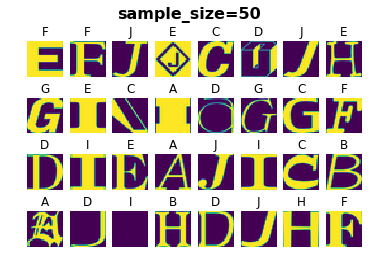

VALIDATION: : 0.5599255742332863 when sample_size= 50
Accuracy: 0.742681623931624 when sample_size= 100


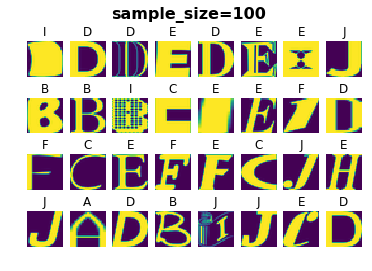

VALIDATION: : 0.6526369819068395 when sample_size= 100
Accuracy: 0.8426816239316239 when sample_size= 1000


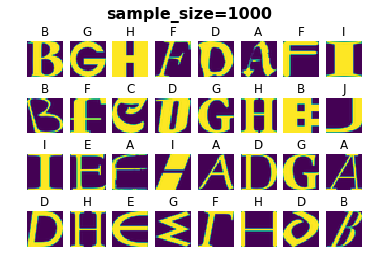

VALIDATION: : 0.7377133324778647 when sample_size= 1000
Accuracy: 0.8572649572649572 when sample_size= 5000


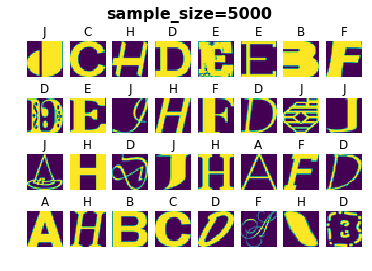

VALIDATION: : 0.7443859874246118 when sample_size= 5000
Accuracy: 0.8852564102564102 when sample_size= 50000


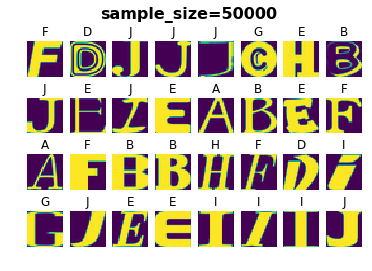

VALIDATION: : 0.7874374438598742 when sample_size= 50000
Accuracy: 0.6497618175155735 when sample_size= 50


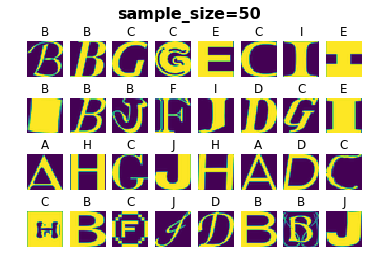

VALIDATION: : 0.5900166816373669 when sample_size= 50
Accuracy: 0.7298644192011726 when sample_size= 100


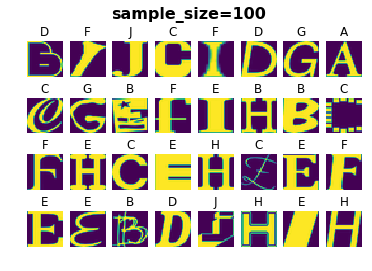

VALIDATION: : 0.6665597330938021 when sample_size= 100
Accuracy: 0.8074752656650788 when sample_size= 1000


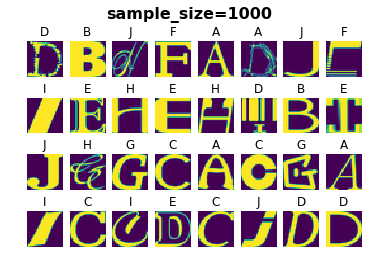

VALIDATION: : 0.7346336455793661 when sample_size= 1000
Accuracy: 0.8268962990106266 when sample_size= 5000


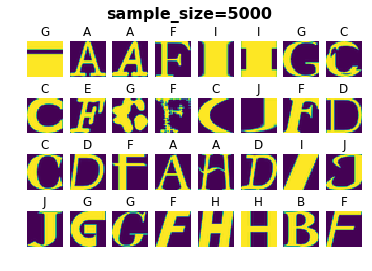

VALIDATION: : 0.7485563967663288 when sample_size= 5000
Accuracy: 0.8620740197874679 when sample_size= 50000


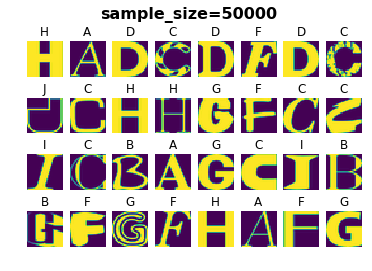

VALIDATION: : 0.7907737713332478 when sample_size= 50000


In [23]:
def disp_sample_dataset(dataset, labels, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 32)
    for i, item in enumerate(items):
        plt.subplot(4, 8, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset[item])
    plt.show()


def train_and_predict_sanitized(sample_size):
    regr = LogisticRegression()
    
    X_train = train_dataset_no2[:sample_size].reshape(sample_size, 28 * 28)
    y_train = train_labels_no2[:sample_size]
    
    regr.fit(X_train, y_train)

    X_test = test_dataset_no2.reshape(test_dataset_no2.shape[0], 28 * 28)
    y_test = test_labels_no2
    X_valid = valid_dataset_no2.reshape(valid_dataset_no2.shape[0], 28 * 28)
    y_valid = valid_labels_no2

    pred_labels = regr.predict(X_test)

    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)
    print('VALIDATION: :', regr.score(X_valid, y_valid), 'when sample_size=', sample_size)
    disp_sample_dataset(test_dataset_no2, pred_labels, 'sample_size=' + str(sample_size))
    
    
def train_and_predict(sample_size):
    regr = LogisticRegression()
    
    X_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
    y_train = train_labels[:sample_size]
    
    regr.fit(X_train, y_train)

    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels
    X_valid = valid_dataset_no2.reshape(valid_dataset_no2.shape[0], 28 * 28)
    y_valid = valid_labels_no2

    pred_labels = regr.predict(X_test)

    print('Accuracy:', regr.score(X_test, y_test), 'when sample_size=', sample_size)
    print('VALIDATION: :', regr.score(X_valid, y_valid), 'when sample_size=', sample_size)
    disp_sample_dataset(test_dataset, pred_labels, 'sample_size=' + str(sample_size))
    


for sample_size in [50, 100, 1000, 5000, 50000]:
    train_and_predict(sample_size)
    
for sample_size in [50, 100, 1000, 5000, 50000]:
    train_and_predict_sanitized(sample_size)